In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc
import time
import os

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.25.2', '2.1.0', '0.20.1', '1.8.1']


# データの生成

LiNGAM の入力データはpandas dataframe で、表頭は不要。

* x0(t) = e0(t)
* x1(t) = x0(t-1) + e1(t)

## 自動的にグラフとデータを生成したい

In [104]:
# Parameters
variable_number = 3
contemporaneous_cause_effect = None
past_cause_effect = [(0,1)] # x0(t-1) --> x1(t)

In [105]:
node_list = []
for var in range(variable_number):
    node_list.append("x"+str(var)+"(t)")
    node_list.append("x"+str(var)+"(t-1)")

In [106]:
import networkx as nx
import matplotlib.pyplot as plt

In [107]:
G = nx.DiGraph()

In [108]:
G.add_nodes_from(node_list)

In [109]:
if contemporaneous_cause_effect != None:
    edge_list = []
    for edge in contemporaneous_cause_effect:
        edge_list.append(("x" + str(edge[0]) + "(t-1)", "x" + str(edge[1]) + "(t)"))
    G.add_edges_from(edge_list)
if past_cause_effect != None:
    edge_list = []
    for edge in past_cause_effect:
        edge_list.append(("x" + str(edge[0]) + "(t-1)", "x" + str(edge[1]) + "(t)"))
    G.add_edges_from(edge_list)

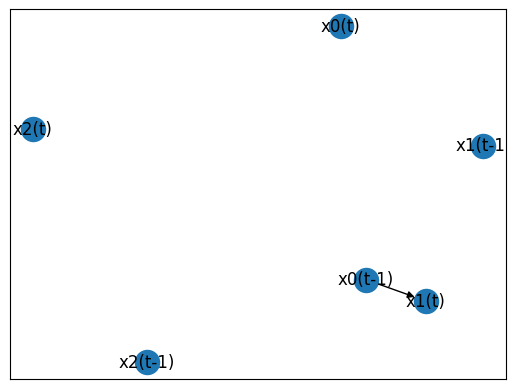

In [110]:
nx.draw_networkx(G)
plt.show()

In [155]:
for i in range(variable_number):
    exec( 'e' + str(i) + "=" + 'np.random.uniform(0,1)' )
    exec( 'x' + str(i) + '_con' + "=" + 'e' + str(i) )
    exec( 'x' + str(i) + '_past' + "=" + '0' )

In [161]:
for time in range(2):
    
    if contemporaneous_cause_effect != None:
        for edge in contemporaneous_cause_effect:
            pass
        
    if past_cause_effect != None:
        for edge in past_cause_effect:
            exec( 'x' + str(edge[1]) + '_con' + "=" + 'x' + str(edge[0]) + "_past" )
        
    

In [162]:
x0_con, x1_con, e0, e1

(0.32474410225680994,
 0.9372465074339074,
 0.32474410225680994,
 0.6125024051770974)

## 手動でデータを生成する

In [164]:
e0 = np.random.uniform(0,1)
e1 = np.random.uniform(0,1)
x0 = e0
x1 = x0 + e1
x0_, x1_, e0_, e1_ = [x0], [x1], [e0], [e1]
for i in range(1000):
    e0 = np.random.uniform(0,1)
    e1 = np.random.uniform(0,1)
    e0_.append(e0)
    e1_.append(e1)
    x1 = x0 + e1
    x0 = e0
    x0_.append(x0)
    x1_.append(x1)

df=pd.DataFrame({
    "x0(t-1)": x0_,
    "x1(t-1)": x1_,
    "e0(t-1)": e0_,
    "e1(t-1)": e1_
});df.head(n=5)

,x0(t-1),x1(t-1),e0(t-1),e1(t-1)
0,0.931539,1.218174,0.931539,0.286634
1,0.126780,1.209133,0.126780,0.277594
2,0.597420,0.650793,0.597420,0.524013
3,0.314957,0.952235,0.314957,0.354815
4,0.384749,1.167752,0.384749,0.852795


In [165]:
df2 = df[1:]
df2 = df2.reset_index()
del df2["index"]
df2.columns = ["x0(t)","x1(t)", "e0(t)", "e1(t)"]

In [166]:
df3 = pd.concat([df2, df], axis=1).dropna()
df4 = pd.DataFrame({
    "x0(t)": df3["x0(t)"],
    "x1(t)": df3["x1(t)"],
    "x0(t-1)": df3["x0(t-1)"],
    "x1(t-1)": df3["x1(t-1)"],
    "e0(t)": df3["e0(t)"],
    "e1(t)": df3["e1(t)"]
});df4

,x0(t),x1(t),x0(t-1),x1(t-1),e0(t),e1(t)
0,0.126780,1.209133,0.931539,1.218174,0.126780,0.277594
1,0.597420,0.650793,0.126780,1.209133,0.597420,0.524013
2,0.314957,0.952235,0.597420,0.650793,0.314957,0.354815
3,0.384749,1.167752,0.314957,0.952235,0.384749,0.852795
4,0.682247,0.441356,0.384749,1.167752,0.682247,0.056607
...,...,...,...,...,...,...
995,0.359037,1.037650,0.326898,0.966876,0.359037,0.710753
996,0.928845,1.116204,0.359037,1.037650,0.928845,0.757167
997,0.443752,1.895906,0.928845,1.116204,0.443752,0.967061
998,0.698756,0.484768,0.443752,1.895906,0.698756,0.041015


In [170]:
# df4.head(n=800).to_csv("C:/Users/Mitsu/Desktop/AISTATS/230908/train_gen.csv", sep=",", encoding="utf-8")
# df4.tail(n=200).to_csv("C:/Users/Mitsu/Desktop/AISTATS/230908/test_gen.csv", sep=",", encoding="utf-8")

In [175]:
df5 = df4[["x0(t)","x1(t)"]]
# df5.head(n=800).to_csv("C:/Users/Mitsu/Desktop/AISTATS/230908/train_dis.csv", sep=",", encoding="utf-8")
# df5.tail(n=200).to_csv("C:/Users/Mitsu/Desktop/AISTATS/230908/test_dis.csv", sep=",", encoding="utf-8")

# VAR-LiNGAM

In [313]:
def Measurements(coeff_pred, coeff_truth):
    TP,TN,FP,FN=0,0,0,0
    for i in range(coeff_pred.shape[0]):
        for j in range(coeff_pred.shape[1]):
            if coeff_pred[i][j] == coeff_truth[i][j]:
                if coeff_pred[i][j]==1.0:
                    # print("True positive", coeff_pred[i][j])
                    TP += 1
                elif coeff_pred[i][j]==0.0:
                    # print("True negative", coeff_pred[i][j])
                    TN += 1
            else:
                if coeff_pred[i][j]==1.0:
                    # print("False positive", coeff_pred[i][j])
                    FP += 1
                elif coeff_pred[i][j]==0.0:
                    # print("False negative", coeff_pred[i][j])
                    FN += 1

    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP+FN)
    F1 = TP / (TP + 1/2 * (FP + FN))
    MyScore = 1 / ( 1 + (FP + FN) )
    MyScore2 = (FP + FN)  / (TP + FP + FN + TN)
    return Accuracy, Precision, Recall, F1, MyScore, MyScore2

In [314]:
# Excelなどが使えずcsvファイルのインデックス列を削除できていない場合
os.chdir("C:/Users/Mitsu/Desktop/AISTATS/230930_VAR-LiNGAM/")
def input_data(filename, num_of_var):
    tmp = pd.read_csv("sample_data_"+str(num_of_var)+"_"+filename, sep=",", encoding="utf-8",header=None)
    # del tmp["Unnamed: 0"]
    return tmp

In [315]:
max_num_of_var = 50
for num_of_var in range(2,max_num_of_var + 1):
    print("num_of_var: ",num_of_var)
    train_gen = input_data(filename="train_gen.csv", num_of_var=num_of_var)
    train_dis = input_data(filename="train_dis.csv", num_of_var=num_of_var)
    test_gen = input_data(filename="test_gen.csv", num_of_var=num_of_var)
    test_dis = input_data(filename="test_dis.csv", num_of_var=num_of_var)
    
    X = train_dis
    del X[X.columns[0]]
    X = X[1:]
    
    labels = []
    for i in range(num_of_var):
        labels.append("x"+str(i)+"(t)")
    for i in range(num_of_var):
        labels.append("x"+str(i)+"(t-1)")

    ##########################################################
    
    tmp = pd.read_csv("sample_data_"+str(num_of_var)+".csv", sep=",", encoding="utf-8")
    del tmp["Unnamed: 0"]
    B0 = np.array(tmp[0:num_of_var])
    B1 = np.array(tmp[num_of_var : num_of_var * 2])
    
    ###########################################################################
    
    time_sta = time.perf_counter()
    # iteration = 10
    # B0_pred = np.zeros([num_of_var,num_of_var])
    # B1_pred = np.zeros([num_of_var,num_of_var])
    # for i in range(iteration):
    model = lingam.VARLiNGAM()
    result = model.bootstrap(X, n_sampling=100)
    # print(model.causal_order_)
    # model.fit(X)
    # B0_pred = model.adjacency_matrices_[0]
    B1_pred = model.adjacency_matrices_[1]
    dlingam = lingam.DirectLiNGAM()
    dlingam.fit(model.residuals_)
    B0_pred = dlingam.adjacency_matrix_
    # cdc = result.get_causal_direction_counts(min_causal_effect=0.01, split_by_causal_effect_sign=True)
    time_end = time.perf_counter()
    tim = time_end- time_sta
    print(tim,"sec.")
    # B0_pred = B0_pred/iteration
    # B1_pred = B1_pred/iteration
    
    ##############################################################
    
    threshold_value_candidate = 100
    alice = pd.DataFrame({})
    for hh in range(threshold_value_candidate):
        for jj in range(threshold_value_candidate):
            prob = result.get_probabilities(min_causal_effect=(jj+1)/threshold_value_candidate)
            h = (hh+1)/threshold_value_candidate
            coeff_pred = np.concatenate([prob[0], prob[1]])
            coeff_pred = np.where(abs(coeff_pred)>h, 1, 0)
            coeff_truth = np.concatenate([B0, B1])
            coeff_truth = np.where(abs(coeff_truth)>h, 1, 0)
            try: 
                Accuracy, Precision, Recall, F1, MyScore, MyScore2 = Measurements(coeff_pred, coeff_truth)
            except ZeroDivisionError:
                pass
            hoge = Accuracy + Precision + Recall + F1 + MyScore
            hoge2 = pd.DataFrame({"hh":[hh], "jj":[jj], "hoge": [hoge], "Acc": [Accuracy], "Prec": [Precision], "Recall": [Recall], "F1": [F1], "MyScore":[MyScore], "MyScore2": [MyScore2] })
            alice = pd.concat([alice, hoge2])
    
    alice = alice.sort_values(['Acc', 'MyScore', 'F1', 'hoge', 'Prec', 'Recall'], ascending=False) # この順番でかなり結果が変わる F1 を前の方にする。
    tmp2 = alice.head(n=1)
    threshold = (tmp2["hh"][0]+1)/threshold_value_candidate
    jj = (tmp2["jj"][0]+1)/threshold_value_candidate
    prob = result.get_probabilities(min_causal_effect=jj)
    coeff_pred = np.concatenate([prob[0], prob[1]])
    coeff_pred = np.where(abs(coeff_pred)>threshold, 1, 0)
    coeff_truth = np.concatenate([B0, B1])
    coeff_truth = np.where(abs(coeff_truth)>threshold, 1, 0)
    Accuracy, Precision, Recall, F1, MyScore, MyScore2 = Measurements(coeff_pred, coeff_truth)
    df = pd.DataFrame({
        "Num_of_var": [num_of_var],
        "Accuracy": [Accuracy],
        "Precision": [Precision],
        "Recall": [Recall],
        "F1": [F1],
        "Error rate": [MyScore2], # 1 - Accuracy （全要素中、何割間違えたか）
        "1/(1+FP+FN)": [MyScore],
        "Time": [tim/100],
        # "DTW": DTW_dict_list,
        # "DTW_mean": DTW_mean_list,
        "Coeff_result": [np.concatenate([B0_pred,B1_pred])],
        # "Coeff_result_std": Coeff_result_std_list,
        "Coeff_Truth": [coeff_truth],
        "Coeff_result_probability": [coeff_pred]
    })
    df.to_csv("Results_VAR-LiNGAM_"+str(num_of_var)+".csv", sep=",", encoding="utf-8")
    print(df)

num_of_var:  2
1.4878927000099793 sec.
   Num_of_var  Accuracy  Precision  Recall        F1  Error rate  1/(1+FP+FN)  \
0           2     0.875        0.5     1.0  0.666667       0.125          0.5   

       Time                                       Coeff_result  \
0  0.014879  [[0.0, 0.0], [0.17696760742832032, 0.0], [0.20...   

                        Coeff_Truth          Coeff_result_probability  
0  [[0, 0], [0, 0], [0, 1], [0, 0]]  [[0, 0], [0, 0], [0, 1], [1, 0]]  
num_of_var:  3
3.240853700088337 sec.
   Num_of_var  Accuracy  Precision  Recall        F1  Error rate  1/(1+FP+FN)  \
0           3  0.888889        1.0     0.5  0.666667    0.111111     0.333333   

       Time                                       Coeff_result  \
0  0.032409  [[0.0, 0.10810460283944154, 0.0969278270593385...   

                                         Coeff_Truth  \
0  [[0, 1, 0], [0, 0, 1], [0, 0, 0], [1, 0, 0], [...   

                            Coeff_result_probability  
0  [[0, 0, 0], [0, 

KeyboardInterrupt: 

# VAR-LiNGAM結果Metrics修正

In [60]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt

In [100]:
def String2List(coeff_pred_prob):
    tmp = coeff_pred_prob.replace(" ",",").replace(",,,",",").replace(",,",",").replace(",,",",").replace("]\n,","]hoge")
    tmp = tmp.replace(",]","]").replace("[[","[").replace("]]","]").replace("[,","[").replace("\n,",",").split("hoge")
    return [eval(var) for var in tmp]

In [101]:
def Measurements(coeff_pred, coeff_truth):
    TP,TN,FP,FN=0,0,0,0
    for i in range(coeff_pred.shape[0]):
        for j in range(coeff_pred.shape[1]):
            if coeff_pred[i][j] == coeff_truth[i][j]:
                if coeff_pred[i][j]==1.0:
                    # print("True positive", coeff_pred[i][j])
                    TP += 1
                elif coeff_pred[i][j]==0.0:
                    # print("True negative", coeff_pred[i][j])
                    TN += 1
            else:
                if coeff_pred[i][j]==1.0:
                    # print("False positive", coeff_pred[i][j])
                    FP += 1
                elif coeff_pred[i][j]==0.0:
                    # print("False negative", coeff_pred[i][j])
                    FN += 1

    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP+FN)
    F1 = TP / (TP + 1/2 * (FP + FN))
    MyScore = 1 / ( 1 + (FP + FN) )
    MyScore2 = (FP + FN)  / (TP + FP + FN + TN)
    return Accuracy, Precision, Recall, F1, MyScore, MyScore2 # 

In [102]:
os.chdir("C:/Users/Mitsu/Desktop/AISTATS/230930_VAR-LiNGAM")

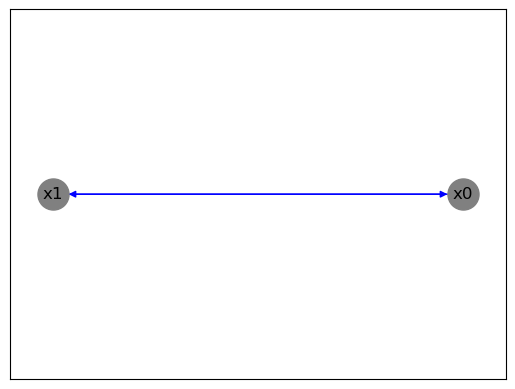

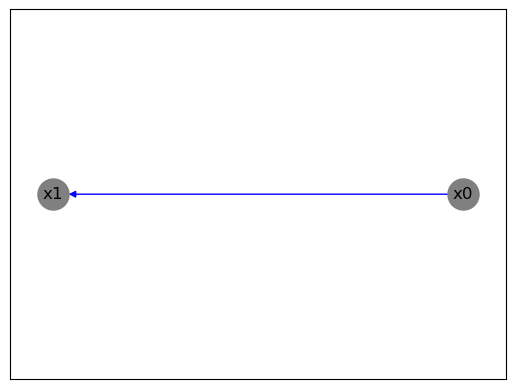

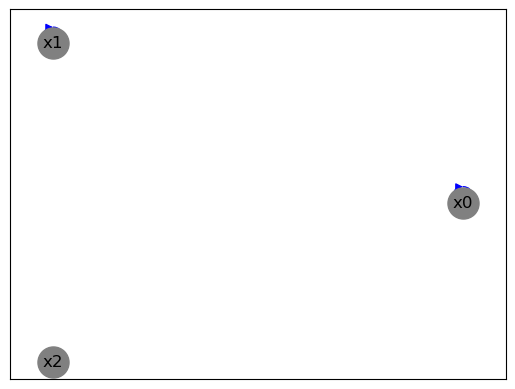

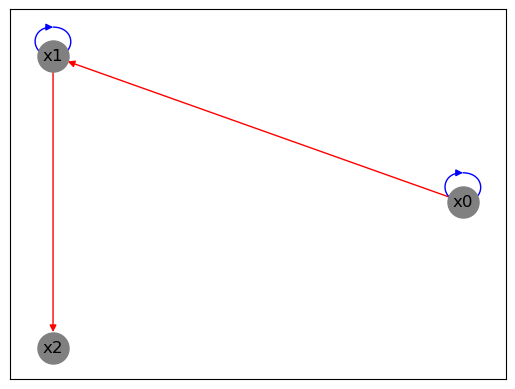

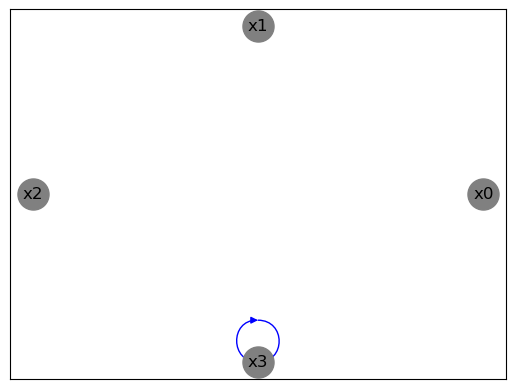

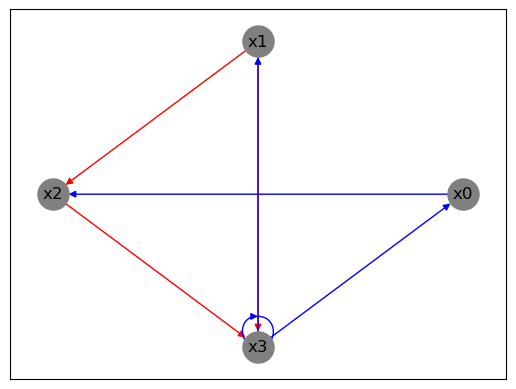

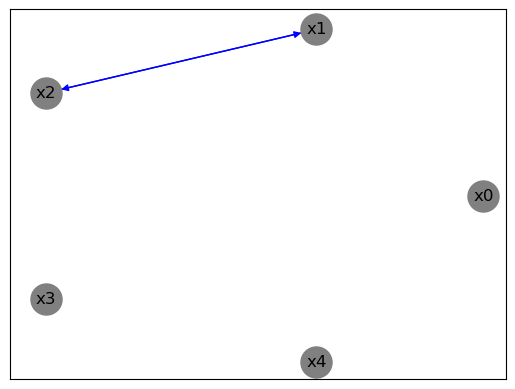

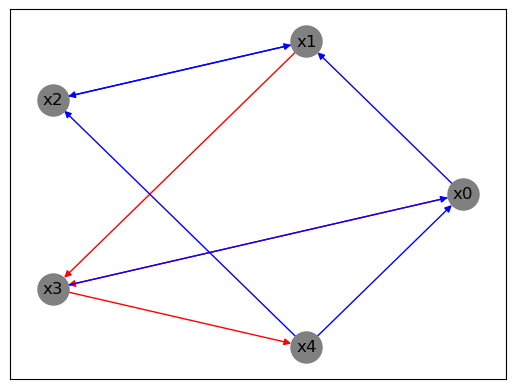

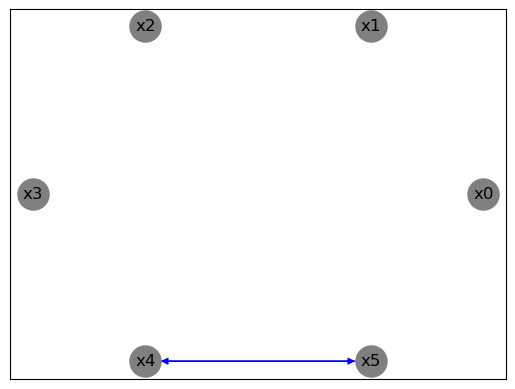

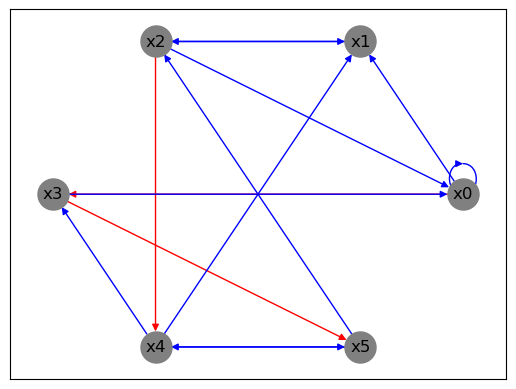

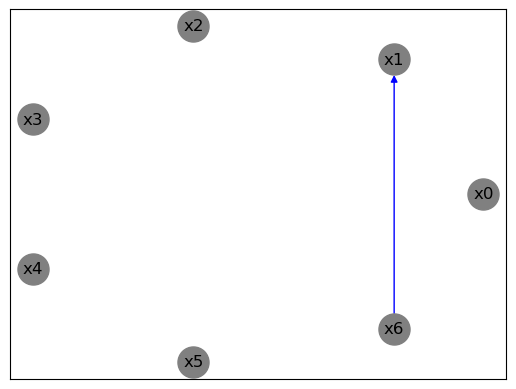

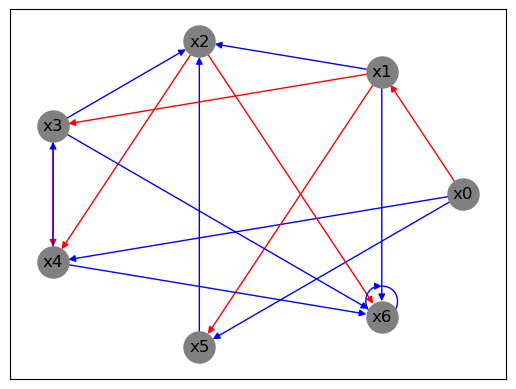

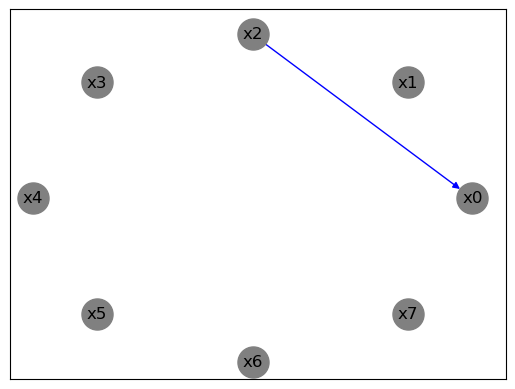

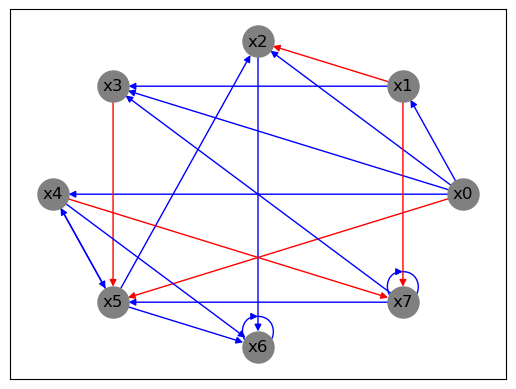

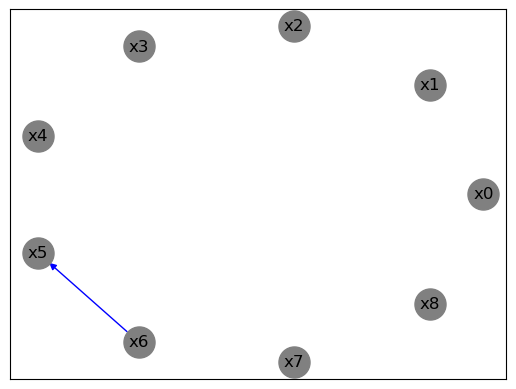

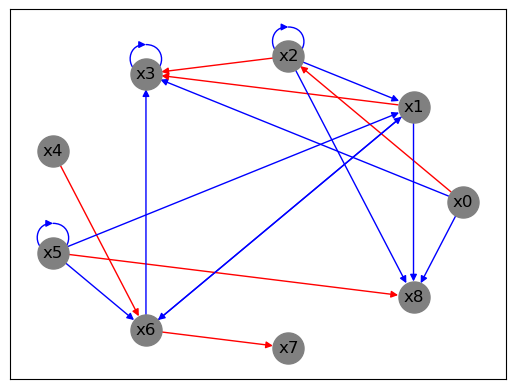

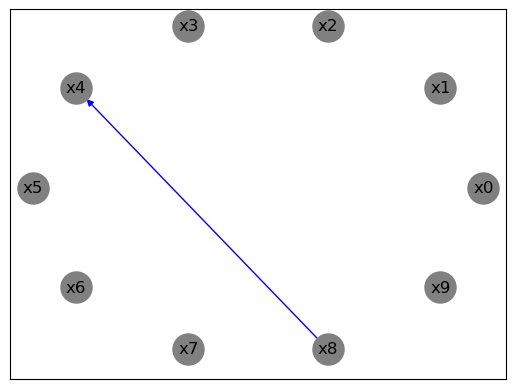

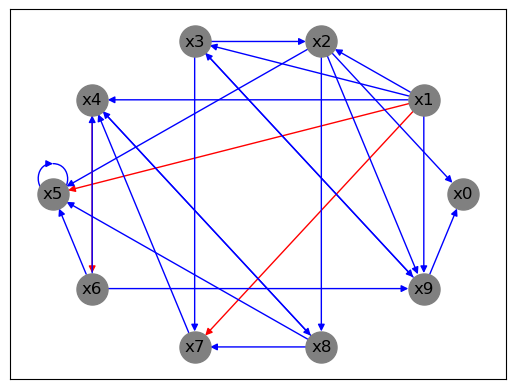

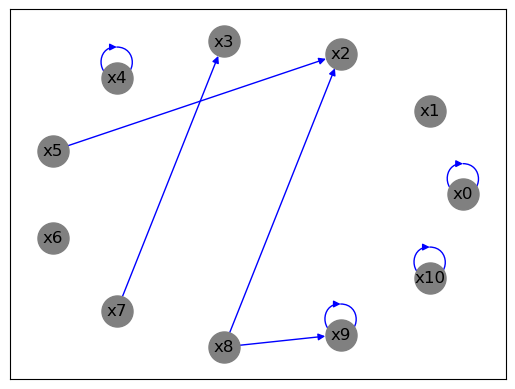

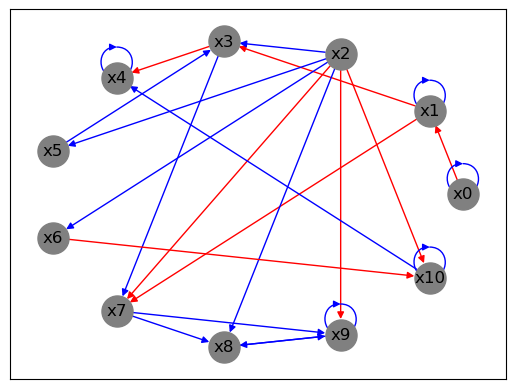

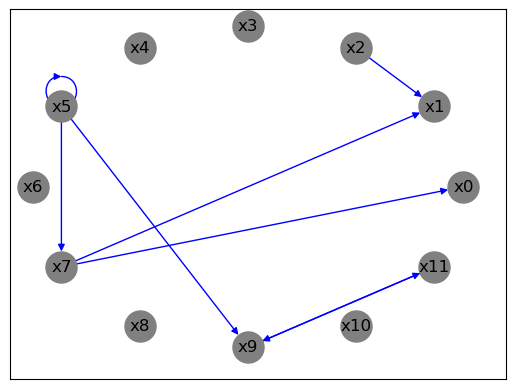

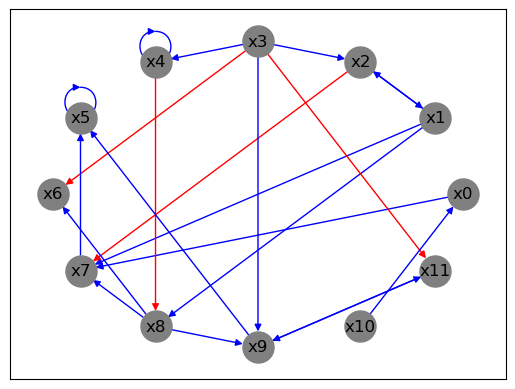

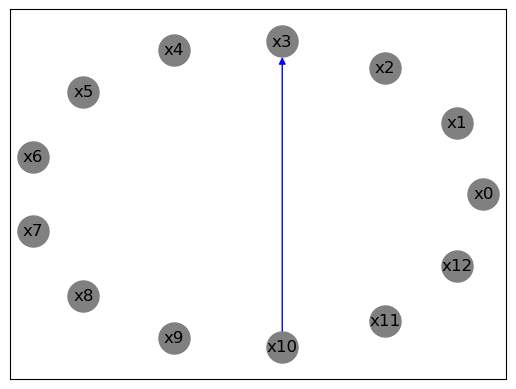

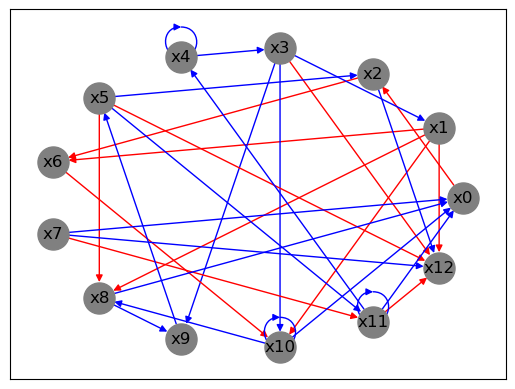

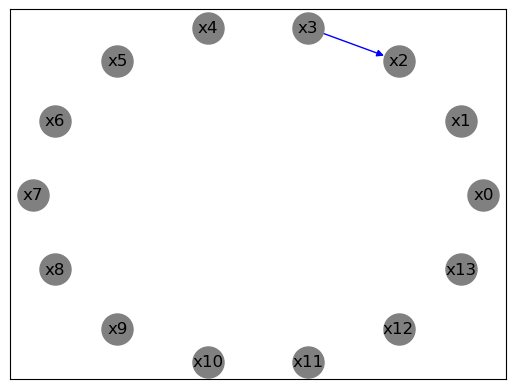

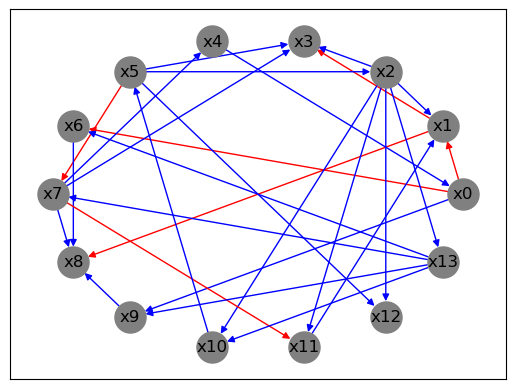

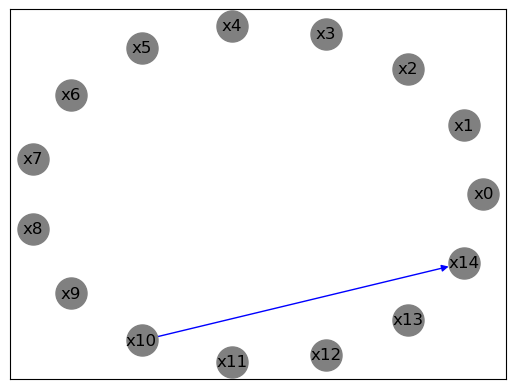

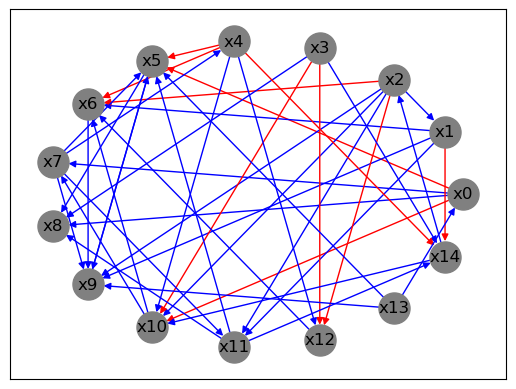

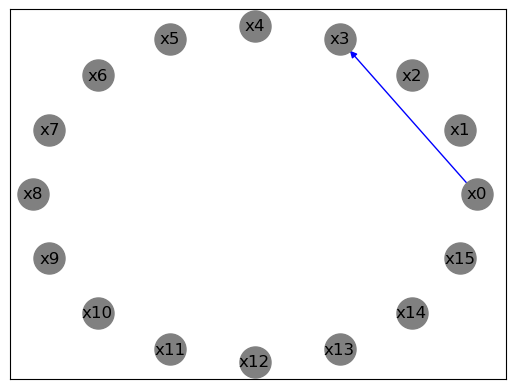

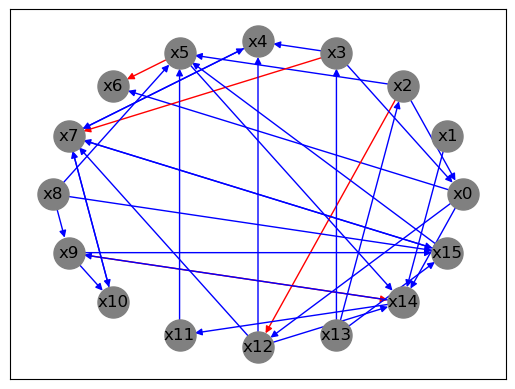

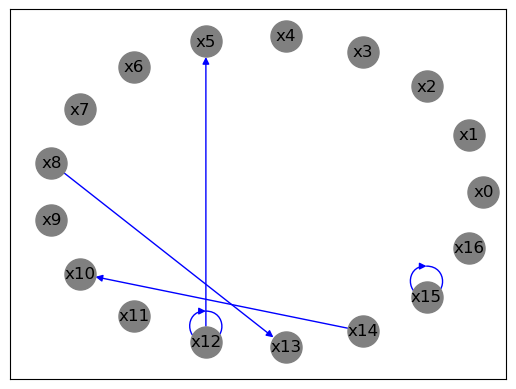

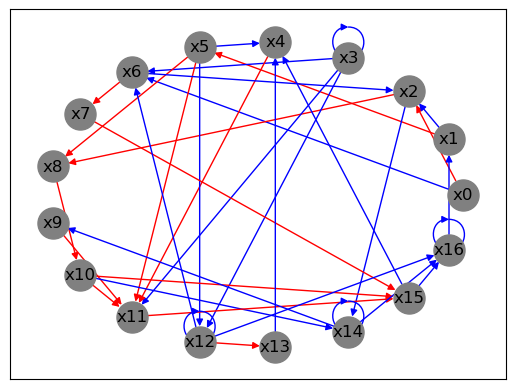

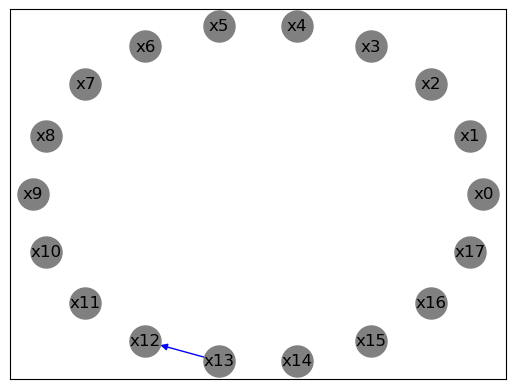

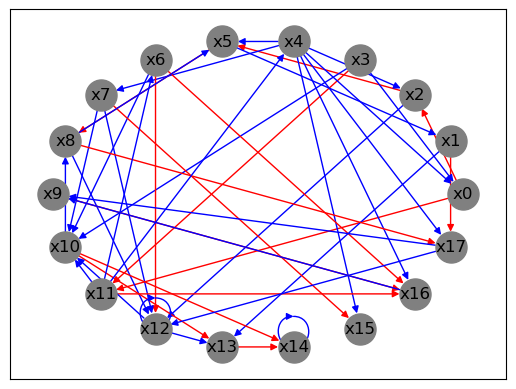

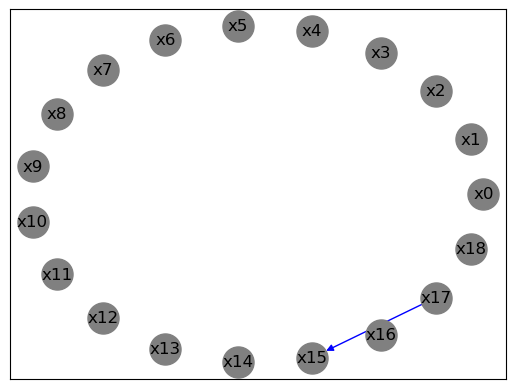

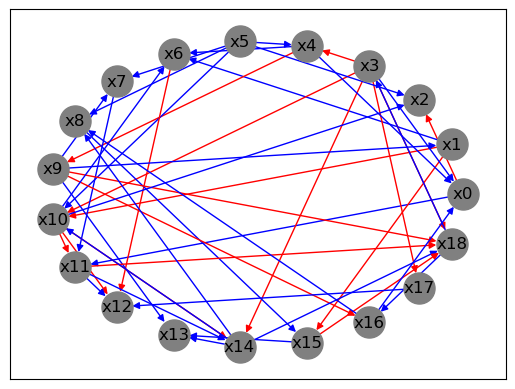

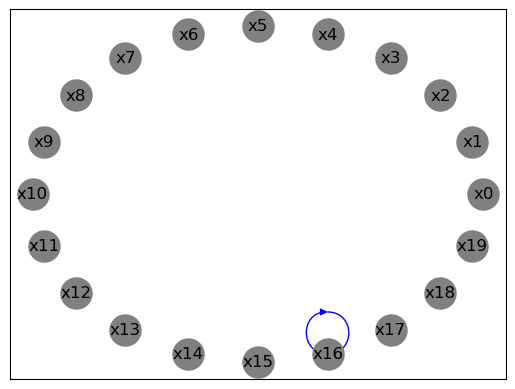

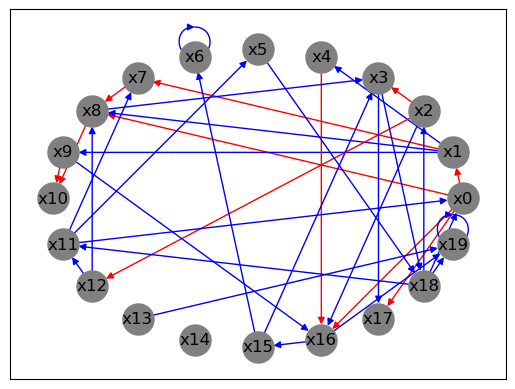

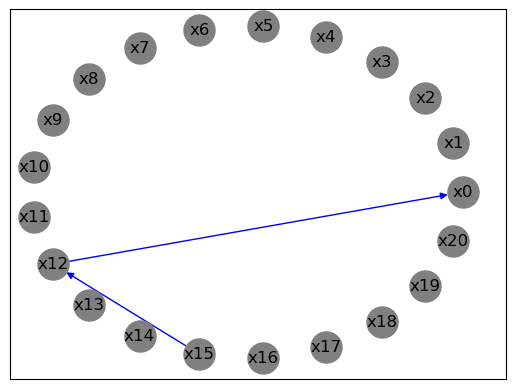

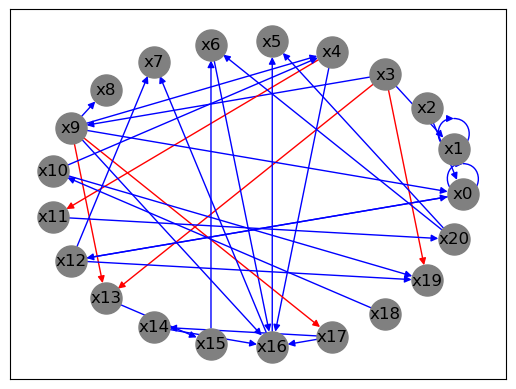

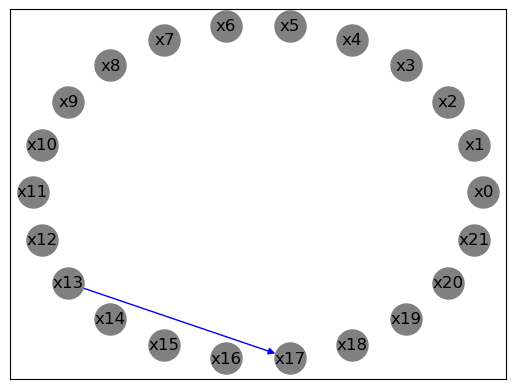

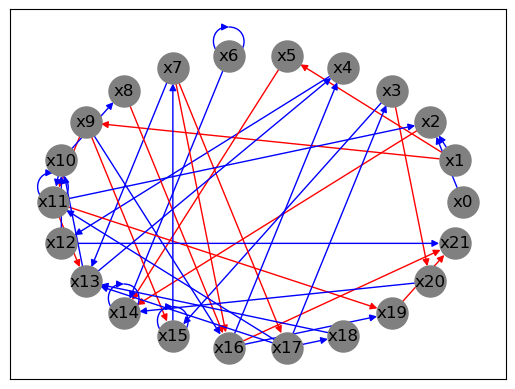

DONE


In [103]:
max_num_of_var = 22
Accuracy_dict, Precision_dict, Recall_dict, F1_dict, MyScore_dict, MyScore2_dict = [],[],[],[],[],[]
Coeff_pred_list, Coeff_truth_list, Coeff_result_list, num_of_var_list, Time_list = [],[],[],[],[]
for num_of_var in range(2,max_num_of_var+1):
    df = pd.read_csv("Results_VAR-LiNGAM_"+str(num_of_var)+".csv", sep=",", encoding="utf-8")
    del df["Unnamed: 0"]
    G = nx.DiGraph()
    ################################################################################
    coeff_pred_prob = df[df["Num_of_var"]==num_of_var]["Coeff_result_probability"].values[0]
    coeff_pred_prob = np.array(String2List(coeff_pred_prob))

    B0_pred = coeff_pred_prob[0:num_of_var]
    B1_pred = coeff_pred_prob[num_of_var:num_of_var*2]
    E_pred = np.diag([1.0]*num_of_var)
    
    G.clear()
    G = nx.DiGraph()

    nodelist = ["x"+str(i) for i in range(num_of_var)]
    G.add_nodes_from(nodelist)

    B0_edge_list = []
    for i in range(len(B0_pred)):
        for j in range(len(B0_pred[i])):
            if  B0_pred[i][j] >= 0.1 :
                B0_edge_list.append(("x"+str(i), "x"+str(j), {"color" : "red"}))

    B1_edge_list = []
    for i in range(len(B1_pred)):
        for j in range(len(B1_pred[i])):
            if  B1_pred[i][j] >= 0.1 :
                B1_edge_list.append(("x"+str(i), "x"+str(j), {"color" : "blue"}))

    G.add_edges_from(B0_edge_list)
    G.add_edges_from(B1_edge_list)

    plt.rcParams["font.family"] = "Arial"
    #To view the directed graph run the following command
    pos = nx.circular_layout(G, scale=1, center=None, dim=2)
    edge_color = [edge["color"] for edge in G.edges.values()]
    nx.draw_networkx(G, pos, font_size=12, font_color="black", node_color="grey", edge_color=edge_color, with_labels = True, node_size=500,width=1)

    plt.savefig("Network_VAR-LiNGAM_"+str(num_of_var)+".png",dpi=300)
    plt.savefig("Network_VAR-LiNGAM_"+str(num_of_var)+".eps",dpi=300)
    plt.savefig("Network_VAR-LiNGAM_"+str(num_of_var)+".svg",dpi=300)
    plt.show()
    #####################################################

    df2 = pd.read_csv("sample_data_"+str(num_of_var)+".csv", sep=",", encoding="utf-8")
    del df2["Unnamed: 0"]
    coeff_truth_prob = df2.values

    B0_truth = coeff_truth_prob[0:num_of_var]
    B1_truth = coeff_truth_prob[num_of_var:num_of_var*2]
    G.clear()
    G = nx.DiGraph()

    nodelist = ["x"+str(i) for i in range(num_of_var)]
    G.add_nodes_from(nodelist)

    B0_edge_list = []
    for i in range(len(B0_truth)):
        for j in range(len(B0_truth[i])):
            if  B0_truth[i][j] >= 0.1 :
                B0_edge_list.append(("x"+str(i), "x"+str(j), {"color" : "red"}))

    B1_edge_list = []
    for i in range(len(B1_truth)):
        for j in range(len(B1_truth[i])):
            if  B1_truth[i][j] >= 0.1 :
                B1_edge_list.append(("x"+str(i), "x"+str(j), {"color" : "blue"}))

    G.add_edges_from(B0_edge_list)
    G.add_edges_from(B1_edge_list)
    plt.rcParams["font.family"] = "Arial"
    #To view the directed graph run the following command
    pos = nx.circular_layout(G, scale=1, center=None, dim=2)
    edge_color = [edge["color"] for edge in G.edges.values()]
    nx.draw_networkx(G, pos, font_size=12, font_color="black", node_color="grey", edge_color=edge_color, with_labels = True, node_size=500,width=1)

    plt.savefig("Network_Truth_"+str(num_of_var)+".png",dpi=300)
    plt.savefig("Network_Truth_"+str(num_of_var)+".eps",dpi=300)
    plt.savefig("Network_Truth_"+str(num_of_var)+".svg",dpi=300)
    plt.show()
    
    
    coeff_pred_prob = np.concatenate([B0_pred,B1_pred,E_pred])
    coeff_truth_prob = np.concatenate([B0_truth,B1_truth,np.diag([1.0]*num_of_var)])
    Accuracy, Precision, Recall, F1, MyScore, MyScore2 = Measurements(coeff_pred_prob, coeff_truth_prob)
    Accuracy_dict.append(Accuracy)
    Precision_dict.append(Precision)
    Recall_dict.append(Recall)
    F1_dict.append(F1)
    MyScore_dict.append(MyScore)
    MyScore2_dict.append(MyScore2)
    Coeff_pred_list.append(coeff_pred_prob)
    Coeff_truth_list.append(coeff_truth_prob)
    coeff_pred = df[df["Num_of_var"]==num_of_var]["Coeff_result"].values[0]
    coeff_pred = np.array(String2List(coeff_pred))
    Coeff_result_list.append(coeff_pred)
    tim = df[df["Num_of_var"]==num_of_var]["Time"].values[0]
    Time_list.append(tim)
    num_of_var_list.append(num_of_var)
    
print("DONE")
df2 = pd.DataFrame({
    "Num_of_var":num_of_var_list,
    "Accuracy":Accuracy_dict,
    "Precision":Precision_dict,
    'Recall':Recall_dict,
    'F1': F1_dict,
    'Error rate':MyScore_dict,
    '1/(1+FP+FN)':MyScore2_dict,
    'Time':Time_list,
    'Coeff_result':Coeff_result_list,
    'Coeff_Truth':Coeff_truth_list,
    'Coeff_result_probability':Coeff_pred_list
})
df2.to_csv("Results_Modified_VAR-LiNGAM.tsv", sep="\t", encoding="utf-8")

# その他

In [309]:
# prob = result.get_probabilities(min_causal_effect=0.2)
# print("===Prediction===")
# print('Probability of B0:\n', prob[0])
# print('Probability of B1:\n', prob[1])
# print("===Truth===")
# print(B0)
# print(B1)

In [318]:
help(result)

Help on VARBootstrapResult in module lingam.var_lingam object:

class VARBootstrapResult(lingam.bootstrap.BootstrapResult)
 |  VARBootstrapResult(adjacency_matrices, total_effects)
 |  
 |  The result of bootstrapping for Time series algorithm.
 |  
 |  Method resolution order:
 |      VARBootstrapResult
 |      lingam.bootstrap.BootstrapResult
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, adjacency_matrices, total_effects)
 |      Construct a BootstrapResult.
 |      
 |      Parameters
 |      ----------
 |      adjacency_matrices : array-like, shape (n_sampling)
 |          The adjacency matrix list by bootstrapping.
 |      total_effects : array-like, shape (n_sampling)
 |          The total effects list by bootstrapping.
 |  
 |  get_paths(self, from_index, to_index, from_lag=0, to_lag=0, min_causal_effect=None)
 |      Get all paths from the start variable to the end variable and their bootstrap probabilities.
 |      
 |      Parameters
 |      -

In [250]:
# Total causal effect
causal_effects = result.get_total_causal_effects(min_causal_effect=jj)
df = pd.DataFrame(causal_effects)

df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,x0(t-1),x1(t),0.720723,1.00
1,x1(t-1),x0(t),0.293429,0.46
2,x1(t-1),x1(t),0.273149,0.44
3,x0(t-1),x0(t),0.230673,0.11


In [74]:
time_sta = time.perf_counter()
model = lingam.VARLiNGAM()
result = model.bootstrap(X, n_sampling=100)
time_end = time.perf_counter()
tim = time_end- time_sta
print(tim,"sec.")

1.4272922000382096 sec.


In [75]:
cdc = result.get_causal_direction_counts(n_directions=4, min_causal_effect=0.3, split_by_causal_effect_sign=True)

In [76]:
print_causal_directions(cdc, 100, labels=labels)

IndexError: list index out of range

In [18]:
cdc

{'from': [2, 1], 'to': [1, 0], 'count': [100, 1], 'sign': [1, 1]}

In [121]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.2, split_by_causal_effect_sign=True)

In [122]:
prob = result.get_probabilities(min_causal_effect=0.1)
print('Probability of B0:\n', prob[0])
print('Probability of B1:\n', prob[1])

Probability of B0:
 [[0.   0.41]
 [0.51 0.  ]]
Probability of B1:
 [[0.7 1. ]
 [1.  1. ]]


In [124]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)
df = pd.DataFrame(causal_effects)

# df['from'] = df['from'].apply(lambda x : labels[x])
# df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,2,0,0.228116,1.00
1,3,0,0.281567,1.00
2,2,1,0.707413,1.00
3,3,1,0.272599,1.00
4,0,1,0.169084,0.52
5,1,0,0.200135,0.44


In [125]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.2, split_by_causal_effect_sign=True)
print_dagc(dagc, 100) # , labels=labels

DAG[0]: 42.0%
	x0 <--- x2 (b>0)
	x0 <--- x3 (b>0)
	x1 <--- x2 (b>0)
DAG[1]: 25.0%
	x0 <--- x3 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)
DAG[2]: 16.0%
	x0 <--- x1 (b>0)
	x0 <--- x3 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)


In [180]:
model = lingam.VARLiNGAM()
model.fit(X)

In [181]:
dlingam = lingam.DirectLiNGAM()
dlingam.fit(model.residuals_)
dlingam.adjacency_matrix_

array([[0.   , 0.   ],
       [0.239, 0.   ]])

In [182]:
model.adjacency_matrices_[0]

array([[0.   , 0.   ],
       [0.239, 0.   ]])

In [183]:
model.adjacency_matrices_[1]

array([[0.285, 0.301],
       [1.245, 0.227]])

In [184]:
model = lingam.VARLiNGAM()
result = model.bootstrap(X, n_sampling=100)

In [185]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.3, split_by_causal_effect_sign=True)

In [186]:
print_causal_directions(cdc, 100, labels=labels)

x1(t) <--- x0(t-1) (b>0) (100.0%)
x0(t) <--- x1(t-1) (b>0) (68.0%)
x1(t) <--- x0(t) (b>0) (1.0%)


In [31]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.2, split_by_causal_effect_sign=True)

In [32]:
print_dagc(dagc, 100, labels=labels)

DAG[0]: 48.0%
	x0(t) <--- x0(t-1) (b>0)
	x0(t) <--- x1(t-1) (b>0)
	x1(t) <--- x0(t) (b>0)
	x1(t) <--- x0(t-1) (b>0)
	x1(t) <--- x1(t-1) (b>0)
DAG[1]: 33.0%
	x0(t) <--- x1(t) (b>0)
	x0(t) <--- x1(t-1) (b>0)
	x1(t) <--- x0(t-1) (b>0)
	x1(t) <--- x1(t-1) (b>0)
DAG[2]: 8.0%
	x0(t) <--- x1(t-1) (b>0)
	x1(t) <--- x0(t-1) (b>0)
	x1(t) <--- x1(t-1) (b>0)


In [33]:
prob = result.get_probabilities(min_causal_effect=0.1)
print('Probability of B0:\n', prob[0])
print('Probability of B1:\n', prob[1])

Probability of B0:
 [[0.   0.47]
 [0.53 0.  ]]
Probability of B1:
 [[0.57 1.  ]
 [1.   1.  ]]


In [34]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)
df = pd.DataFrame(causal_effects)

df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,x0(t-1),x0(t),0.365610,1.00
1,x1(t-1),x0(t),0.303746,1.00
2,x0(t-1),x1(t),1.274579,1.00
3,x1(t-1),x1(t),0.355831,1.00
4,x0(t),x1(t),0.243043,0.53
5,x1(t),x0(t),0.250389,0.47
